##### Advanced Statistical Analysis and Model-Based Learning (Fall 2024-2025)
# Home Assignment 5

#### Due: 27/01/2025 by 18:30

#### Instructions:
- Write your name, Student ID, and date in the cell below.
- Submit a copy of this notebook with code filled in the relevant places as the solution of coding excercises.
- For theoretic excercises, you can either write your solution in the notebook using $\LaTeX$ or submit additional notes.

<hr>

Adi Dereviani 305674731

Ofri Hefetz  209028067
<hr>

<hr>
<hr>

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
import numpy as np
import scipy
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_squared_error
import itertools
from sklearn.linear_model import LassoCV
from IPython.display import display
from itertools import combinations
from joblib import Parallel, delayed
from sklearn.linear_model import Lasso
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import ttest_ind


## Problem 1: Multiple Regression

Use the attached cars dataset that was used in the EDA notebook. Load it using the function `load_cars_data`. We will use `MSRP` as the target variable (note that this is a transformed version of the original MSRP).

1. Use all variables in the data returned by `load_cars_data`. Find at least one pair of competing predictors.
2. A car manufacturer is trying to figure out how to design a new vehicle for maximal profitability. They propose that since `EngineCylinders` is correlated with `MSRP`, they should try to maximize engine cylinders in their designs. Does this conclusion make sense considering that `EngineCylinders` is correlated with `Engine HP`? Offer a procedure that checks the effect of `Engine HP` on `MSRP` and provides more information to make such a decision.


In [71]:
def load_cars_data(path="cars_dataset.csv", q=0.05):
    """
    Args:
    -----
    path: path to csv file

    Load and clean cars data:
        - Filters for numeric predictors only
        - Renames variables to ensure all variable names begin with [a-z]
        - Applies a variance stabilizing transformation to MSRP
        - Removes outliers
    """

    def detect_outliers(df, q):
        """
        Quantile-based outlier detection
        Args:
        -----
        df: DataFrame
        q: quantile threshold
        """
        lower_outliers = df < df.quantile(q)
        upper_outliers = df > df.quantile(1 - q)
        return lower_outliers | upper_outliers

    data_raw = pd.read_csv(path)

    # Select only numeric columns and drop rows with missing values
    data1 = data_raw.select_dtypes('number').dropna()

    # Rename variables to ensure all start with [a-z]
    data1 = data1.rename(columns={
        'Engine HP': 'EngineHP',
        'Engine Cylinders': 'EngineCylinders',
        'Number of Doors': 'NumberOfDoors',
        'highway MPG': 'HighwayMPG',
        'city mpg': 'CityMPG'
    })

    # Select relevant variables
    variables = [
        'MSRP', 'Popularity', 'EngineHP', 'EngineCylinders',
        'HighwayMPG', 'CityMPG', 'NumberOfDoors'
    ]
    data1 = data1.filter(variables).dropna()

    # Detect and remove outliers
    ol = detect_outliers(data1, q).sum(1)
    print(f"Masked a fraction of {ol.mean()} of the data due to outliers")
    return data1[ol == 0]

In [32]:
# Load and clean the cars data
cleaned_data = load_cars_data()
cleaned_data

Masked a fraction of 0.36335167160389337 of the data due to outliers


,MSRP,Popularity,EngineHP,EngineCylinders,HighwayMPG,CityMPG,NumberOfDoors
0,46135,3916,335.0,6.0,26,19,2.0
1,40650,3916,300.0,6.0,28,19,2.0
2,36350,3916,300.0,6.0,28,20,2.0
3,29450,3916,230.0,6.0,28,18,2.0
4,34500,3916,230.0,6.0,28,18,2.0
...,...,...,...,...,...,...,...
11908,50520,204,300.0,6.0,23,16,4.0
11909,46120,204,300.0,6.0,23,16,4.0
11910,56670,204,300.0,6.0,23,16,4.0
11911,50620,204,300.0,6.0,23,16,4.0


In [33]:
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9372 entries, 0 to 11912
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   MSRP             9372 non-null   int64  
 1   Popularity       9372 non-null   int64  
 2   EngineHP         9372 non-null   float64
 3   EngineCylinders  9372 non-null   float64
 4   HighwayMPG       9372 non-null   int64  
 5   CityMPG          9372 non-null   int64  
 6   NumberOfDoors    9372 non-null   float64
dtypes: float64(3), int64(4)
memory usage: 585.8 KB


#### 1.1

A we learnd in class about competing variables:

- $β̂_1$ is significant if #x_2# is not in the model
- $β̂_2$ is significant if #x_1# is not in the model



In [34]:
def find_competing_predictors(X, y):

    results = []
    predictors = X.columns
    full_model = sm.OLS(y, sm.add_constant(X)).fit()   # Fit the full model
    full_p_values = full_model.pvalues

    # exclude each predictor, and refit the model
    for excluded_predictor in predictors:
        remaining_predictors = X.drop(columns=[excluded_predictor])
        model = sm.OLS(y, sm.add_constant(remaining_predictors)).fit()
        p_values = model.pvalues

        # calc p-values
        for predictor in predictors:
            # if a predictor is significant only when another is excluded
            if predictor != excluded_predictor:
                was_insignificant = full_p_values[predictor] > 0.05
                became_significant = p_values[predictor] <= 0.05

                if was_insignificant and became_significant:
                    results.append({
                        "Excluded Predictor": excluded_predictor,
                        "Significant Predictor": predictor,
                        "Full Model p-value": full_p_values[predictor],
                        "After Exclusion p-value": np.float64(p_values[predictor])
                    })

    return pd.DataFrame(results)

In [35]:
X_cleaned = cleaned_data.drop(columns=['MSRP'])
y_cleaned = cleaned_data['MSRP']
competing_predictors = find_competing_predictors(X_cleaned, y_cleaned)
display(competing_predictors)

,Excluded Predictor,Significant Predictor,Full Model p-value,After Exclusion p-value
0,EngineHP,Popularity,0.298795,3.237769e-02
1,EngineHP,HighwayMPG,0.282520,2.211457e-75
2,EngineCylinders,HighwayMPG,0.282520,1.592391e-02
3,CityMPG,HighwayMPG,0.282520,1.196202e-107


From the results shown above in the table, we can conclude the following:

1. Popularity and EngineHP:

 Popularity is not significant in the full model $p=0.299$. However, when EngineHP is excluded, Popularity becomes significant $p=0.032$. This means that Popularity and EngineHP are competing variables. Their interplay affects significance, as EngineHP captures information that overlaps with Popularity.


2. HighwayMPG and other predictors:

 HighwayMPG is not significant in the full model $p=0.283$. When CityMPG is excluded, HighwayMPG becomes highly significant. When EngineCylinders is excluded, HighwayMPG also becomes significant p=0.016.
 When EngineHP is excluded, HighwayMPG becomes significant.

**HighwayMPG competes with multiple variables (CityMPG, EngineHP, and EngineCylinders). These predictors overlap in their ability to explain variance in the target (MSRP).

#### 1.2

A car manufacturer’s proposal to maximize EngineCylinders to increase MSRP does not make sense without further analysis because:
- EngineCylinders is correlated with EngineHP, which might be the true driver of MSRP.
- Correlation does not imply causation. EngineHP could mediate the apparent relationship between EngineCylinders and MSRP.

To evaluate this proposal, we perform the 5 analyses steps:

Step 1: Calculate the raw correlation between EngineCylinders and MSRP.

Step 2: Calculate the partial correlation between EngineCylinders and MSRP, adjusted for EngineHP.

Step 3: Fit a combined model (MSRP ~ EngineHP + EngineCylinders) to assess their independent effects.

Step 4: Fit an interaction model (MSRP ~ EngineHP * EngineCylinders) to evaluate how they influence MSRP.

In [36]:
msrp_data = cleaned_data['MSRP']
engine_cylinders_data = cleaned_data[['EngineCylinders']]

# Fit MSRP as a function of EngineCylinders
model_msrp_on_cylinders = sm.OLS(msrp_data, sm.add_constant(engine_cylinders_data)).fit()
model_msrp_on_cylinders_correlation = (
    np.sign(model_msrp_on_cylinders.params['EngineCylinders']) * np.sqrt(model_msrp_on_cylinders.rsquared)
)
print(f"The raw correlation between MSRP and EngineCylinders is: {model_msrp_on_cylinders_correlation:.3f}")

The raw correlation between MSRP and EngineCylinders is: 0.367


The moderate positive raw correlation $0.367$ between MSRP and EngineCylinders suggests a relationship, but further analysis is needed to determine if this effect is independent of EngineHP.

In [37]:
engine_hp_data = cleaned_data[['EngineHP']]

# Regress EngineCylinders on EngineHP
model_cylinders_on_hp = sm.OLS(engine_cylinders_data, sm.add_constant(engine_hp_data)).fit()

# Regress MSRP on EngineHP
model_msrp_on_hp = sm.OLS(msrp_data, sm.add_constant(engine_hp_data)).fit()

# Residuals-based regression for partial corr
model_res = sm.OLS(
    model_msrp_on_hp.resid,
    sm.add_constant(pd.DataFrame({'EngineCylinders': model_cylinders_on_hp.resid}))
).fit()

partial_corr_coeff = (
    np.sign(model_res.params['EngineCylinders']) * np.sqrt(model_res.rsquared)
)
print(f"The partial correlation between MSRP and EngineCylinders adjusted for EngineHP is: {partial_corr_coeff:.3f}")

The partial correlation between MSRP and EngineCylinders adjusted for EngineHP is: -0.378


The negative partial correlation ($−0.378$) between MSRP and EngineCylinders, adjusted for EngineHP, suggests that once the influence of EngineHP is accounted for, EngineCylinders has an inverse relationship with MSRP, indicating it may not independently contribute positively to profitability.

In [38]:
combined_model = smf.ols(formula="MSRP ~ EngineHP + EngineCylinders", data=cleaned_data).fit()
print("\nCombined Model Summary:")
print(combined_model.summary())


Combined Model Summary:
                            OLS Regression Results                            
Dep. Variable:                   MSRP   R-squared:                       0.634
Model:                            OLS   Adj. R-squared:                  0.634
Method:                 Least Squares   F-statistic:                     8103.
Date:                Mon, 27 Jan 2025   Prob (F-statistic):               0.00
Time:                        11:01:46   Log-Likelihood:            -1.0032e+05
No. Observations:                9372   AIC:                         2.007e+05
Df Residuals:                    9369   BIC:                         2.007e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        

- The negative coefficient for EngineCylinders indicates that the manufacturer's proposal to maximize EngineCylinders for profitability does not hold when accounting for EngineHP.Instead, the focus should be on maximizing EngineHP, as it has a direct and positive effect on MSRP.

- The significant negative relationship suggests that increasing EngineCylinders without improving EngineHP could reduce profitability, possibly due to inefficiencies or consumer preferences.

- Furthermore, the model's $R^2 = 0.634$ indicates that $ 63.4 $% of the variation in MSRP is explained by EngineHP and EngineCylinders, highlighting that this combination provides a strong predictive framework for profitability.

In [39]:
interaction_model = smf.ols(formula="MSRP ~ EngineHP * EngineCylinders", data=cleaned_data).fit()
print("\nInteraction Model Summary:")
print(interaction_model.summary())


Interaction Model Summary:
                            OLS Regression Results                            
Dep. Variable:                   MSRP   R-squared:                       0.639
Model:                            OLS   Adj. R-squared:                  0.638
Method:                 Least Squares   F-statistic:                     5517.
Date:                Mon, 27 Jan 2025   Prob (F-statistic):               0.00
Time:                        11:01:46   Log-Likelihood:            -1.0026e+05
No. Observations:                9372   AIC:                         2.005e+05
Df Residuals:                    9368   BIC:                         2.006e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------

- The significant interaction term suggests that the relationship between EngineCylinders and MSRP changes depending on the value of EngineHP.

- If EngineHP is high, the negative effect of EngineCylinders on MSRP might be mitigated.
- If EngineHP is low, increasing EngineCylinders might reduce MSRP more significantly.
- This underscores that simply increasing EngineCylinders without considering EngineHP can lead to suboptimal results.

- The slight increase in $R^2$ compared to the combined model (0.634 vs. 0.639) indicates that adding the interaction term improves the model, but only marginally.

**Conclusion for the Manufacturer:**

The proposal to maximize EngineCylinders is not valid without optimizing EngineHP. EngineHP has a strong positive effect on MSRP, explaining 57.3% of its variability, while EngineCylinders alone explains only 13.5% and has a negative effect in the combined model. The significant interaction between EngineHP and EngineCylinders shows that their relationship with MSRP is interconnected. The focus should be optimizing EngineHP while balancing it with EngineCylinders to maximize profitability.

## Problem 2  - (Variable Selection)

Use life expectancy dataset from class website. Remove entries from 2015; Remove entries with missing values; remove the categorical variable ``Country`` and transform the categorical variable ``Status`` to binary; see provided function.

1. Write the function ``backward_select`` (prototype below). Make sure that your function prints $R^2$ and F-test $p$-value of each candidate model it iterates through in the process.
Apply it on the house prices dataset and report the resulting model.
2. Write a function that receives as an input a set of predictors and the response and evaluates the leave-one-out error (n-fold cross validation). What is the leave-one-out error of the model you found in 1?
3. Consider the predictors:
``
[infant_deaths, BMI, Status_binary, Alcohol, Diphtheria, HIV, Schooling, under_five_deaths, Income_composition_of_resources]
``.
Over each of the $2^9$ models, evaluate $\mathrm{MSE}$, AIC, BIC, $C_p$, and leave-one-out CV-error for every model and print the results. Report on the models with the lowest AIC, BIC, LOO-CV-error, $C_p$.
4. Consider the 4 most dominant predictors as seen in the Lasso path in class. Construct a model with these predictors and evaluate its LOO-CV-error. Add this

Hint: for 1, modify the ``forward_select`` function from class. You may also use the function ``sm.stats.anova_lm(smaller_model, larger_model)`` to compare two ``statsmodels`` models.

In [40]:
def read_and_prepare_life_expectancy_data(path_to_csv_file):
    """
    1. Load dataset from csv file
    2. Remove entries with missing values
    3. Remove spaces from column names
    4. Add a dummy varaible based on `Status` columns
    5. Remove non-numerical variables `Status` and `Country`
    """
    data = pd.read_csv(path_to_csv_file).dropna()
    data.columns = ["_".join(c.split()) for c in data.columns]
    data['Status_binary'] = data['Status'].apply(lambda x : 1 if x=='Developing' else 0)
    data_no_2015 = data[data['Year'] <= 2015] # Remove 2015 data
    non_numeric_vars = ["Status", "Country"]
    data_numeric = data_no_2015.drop(columns = non_numeric_vars)
    data_nona = data_numeric.dropna()
    return data_nona

In [41]:
life_expectancy_df =  read_and_prepare_life_expectancy_data('/content/Life Expectancy Data.csv')

In [42]:
life_expectancy_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1649 entries, 0 to 2937
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Year                             1649 non-null   int64  
 1   Life_expectancy                  1649 non-null   float64
 2   Adult_Mortality                  1649 non-null   float64
 3   infant_deaths                    1649 non-null   int64  
 4   Alcohol                          1649 non-null   float64
 5   percentage_expenditure           1649 non-null   float64
 6   Hepatitis_B                      1649 non-null   float64
 7   Measles                          1649 non-null   int64  
 8   BMI                              1649 non-null   float64
 9   under_five_deaths                1649 non-null   int64  
 10  Polio                            1649 non-null   float64
 11  Total_expenditure                1649 non-null   float64
 12  Diphtheria               

#### 2.1

In [43]:
def backward_select(data, response, sig_level=.05):
    """Linear model designed by backward selection.

    Parameters:
    -----------
    data: pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    sig_level:  significance level for F-test

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept selected by backward selection
           evaluated by R-squared and F-test for extra sum of squares
    """
    remaining = [c for c in data.columns if not c == response]
    rejected_candidates = []

    n = len(data)
    formula = f"{response} ~ {' + '.join(remaining)} + 1"
    current_model = smf.ols(formula, data).fit()
    SS_prev = current_model.ssr

    itr = 0
    while remaining:
        itr += 1
        p_values = current_model.pvalues.drop("Intercept")
        max_p_value = p_values.max()
        worst_candidate = p_values.idxmax()

        if max_p_value > sig_level:
            remaining.remove(worst_candidate)
            rejected_candidates.append((worst_candidate, max_p_value))
            formula = f"{response} ~ {' + '.join(remaining)} + 1"
            new_model = smf.ols(formula, data).fit()
            SS_new = new_model.ssr

            f = (SS_prev - SS_new) / (SS_new / (n - (len(remaining) + 1)))
            Ftest_pval = scipy.stats.f.sf(f, dfn=1, dfd=(n - len(remaining) + 1))

            print(f"=========  Step {itr} ==========")
            print(f"Removed Candidate = {worst_candidate}")
            print(f"New R2 = {new_model.rsquared}")
            print(f"Ftest (pvalue) = {Ftest_pval}")
            print("=============================")

            current_model = new_model
            SS_prev = SS_new
        else:
            print(f"No predictors with p-value > {sig_level}. Stopping.")
            break

    print("Rejected Candidates:")
    for candidate, p_value in rejected_candidates:
        print(f"{candidate}: p-value = {p_value:.4f}")

    return current_model

In [44]:
# Apply the backward_select function to the life expectancy dataset
response_variable = "Life_expectancy"
final_model = backward_select(life_expectancy_df, response_variable)

=========  Step 1 ==========
Removed Candidate = thinness_1_19_years
New R2 = 0.8385751627787918
Ftest (pvalue) = 1.0
=========  Step 2 ==========
Removed Candidate = Population
New R2 = 0.8385627055389225
Ftest (pvalue) = 1.0
=========  Step 3 ==========
Removed Candidate = Hepatitis_B
New R2 = 0.8385103901350186
Ftest (pvalue) = 1.0
=========  Step 4 ==========
Removed Candidate = GDP
New R2 = 0.8384364015323245
Ftest (pvalue) = 1.0
=========  Step 5 ==========
Removed Candidate = Measles
New R2 = 0.8383511935389818
Ftest (pvalue) = 1.0
=========  Step 6 ==========
Removed Candidate = Polio
New R2 = 0.8382423421545568
Ftest (pvalue) = 1.0
No predictors with p-value > 0.05. Stopping.
Rejected Candidates:
thinness_1_19_years: p-value = 0.9119
Population: p-value = 0.7230
Hepatitis_B: p-value = 0.4675
GDP: p-value = 0.3875
Measles: p-value = 0.3537
Polio: p-value = 0.2945


In [45]:
final_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Life_expectancy   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     604.8
Date:                Mon, 27 Jan 2025   Prob (F-statistic):               0.00
Time:                        11:01:47   Log-Likelihood:                -4422.9
No. Observations:                1649   AIC:                             8876.
Df Residuals:                    1634   BIC:                             8957.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                         310.0869     45.397      6.831      0.000     221.045     399.129
Year                               -0.1277      0.023     -5.632      0.000      -0.172      -0.083
Adult_Mortality                    -0.0163      0.001    -17.275      0.000      -0.018      -0.014
infant_deaths                       0.0861      0.010      8.682      0.000       0.067       0.106
Alcohol                            -0.1299      0.034     -3.877      0.000      -0.196      -0.064
percentage_expenditure              0.0005   5.88e-05      7.690      0.000       0.000       0.001
BMI                                 0.0320      0.006      5.421      0.000       0.020       0.044
under_five_deaths                  -0.0652      0.007     -8.846      0.000      -0.080      -0.051
Total_expenditure                   0.0920      0.040      2.284      0.023       0.013       0.171
Diphtheria                          0.0151      0.004      3.368      0.001       0.006       0.024
HIV                                -0.4478      0.018    -25.203      0.000      -0.483      -0.413
thinness_5_9_years                 -0.0521      0.026     -1.992      0.046      -0.103      -0.001
Income_composition_of_resources    10.5232      0.829     12.690      0.000       8.897      12.150
Schooling                           0.9047      0.058     15.493      0.000       0.790       1.019
Status_binary                      -0.8975      0.333     -2.696      0.007      -1.550      -0.245
==============================================================================
Omnibus:                       32.222   Durbin-Watson:                   0.711
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               58.762
Skew:                          -0.110   Prob(JB):                     1.74e-13
Kurtosis:                       3.898   Cond. No.                     1.19e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.19e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Backward Summary

Initial Model:

Started with all predictors in the dataset.
Iteratively removed variables with the highest p-values until no predictors had a p-value above the significance level ($p>0.05
$).


Variables Removed:

1. thinness_1_19_years: $p-value=0.9119$
2. Population: $p-value=0.7230$
3. Hepatitis_B: $p-value=0.4675$
4. GDP: $p-value=0.3875$
5. Measles: $p-value=0.3537$
6. Polio: $p-value=0.2945$

Final Model:

Retained 14 predictors:

Year, Adult_Mortality, infant_deaths, Alcohol, percentage_expenditure, BMI, under_five_deaths, Total_expenditure, Diphtheria, HIV, thinness_5_9_years, Income_composition_of_resources, Schooling, and Status_binary.

$𝑅^2 = 0.838$

$R^2_{Adjusted } = 0.837$

The final model's $R^2$ indicates that 83.8% of the variance in the response variable (Life_expectancy) is explained by the predictors in the model.

#### 2.2

In [72]:
def leave_one_out_error(data, predictors, response):
    """
    Evaluates the Leave-One-Out (LOO) error for a linear model using a vectorized approach.

    Parameters:
    -----------
    data : pandas DataFrame
        The dataset containing predictors and response.
    predictors : list of str
        The names of the predictor variables.
    response : str
        The name of the response variable.

    Returns:
    --------
    loo_error : float
        The mean squared error from leave-one-out cross-validation.
    """
    X = sm.add_constant(data[predictors])
    y = data[response]

    # Fit the model
    model = sm.OLS(y, X).fit()

    # Compute the Hat matrix
    X_matrix = X.to_numpy()
    H = X_matrix @ np.linalg.inv(X_matrix.T @ X_matrix) @ X_matrix.T
    H_diag = np.diag(H)
    y_hat = model.fittedvalues
    residuals = y - y_hat

    loo_errors = (residuals / (1 - H_diag)) ** 2

    loo_error = np.mean(loo_errors)
    return loo_error

In [47]:
final_predictors = ['Year', 'Adult_Mortality', 'infant_deaths', 'Alcohol', 'percentage_expenditure',
                    'BMI', 'under_five_deaths', 'Total_expenditure', 'Diphtheria', 'HIV',
                    'thinness_5_9_years', 'Income_composition_of_resources', 'Schooling', 'Status_binary']
response_variable = "Life_expectancy"

# leave-one-out error for the final model
loo_error = leave_one_out_error(life_expectancy_df, final_predictors, response_variable)
loo_error

12.80376092420579

#### 2.3

In [48]:
predictors = ['infant_deaths', 'BMI', 'Status_binary', 'Alcohol', 'Diphtheria',
              'HIV', 'Schooling', 'under_five_deaths', 'Income_composition_of_resources']
response = 'Life_expectancy'

In [73]:
def evaluate_model(data, predictors, response, subset, sigma2_hat):
    """
    Evaluate a single subset and calculate metrics.
    """
    subset = list(subset)
    X = sm.add_constant(data[subset])
    y = data[response]
    model = sm.OLS(y, X).fit()

    # Metrics
    mse = model.mse_resid
    aic = model.aic
    bic = model.bic
    n = len(data)
    p = model.df_model + 1
    cp = model.ssr / sigma2_hat + 2 * p - n
    loo_cv_error = leave_one_out_error(data, subset, response)

    return {'Subset': subset, 'MSE': mse, 'AIC': aic, 'BIC': bic, 'Cp': cp, 'LOO-CV': loo_cv_error}


def evaluate_all_models(data, predictors, response, n_jobs=-1):
    """
    Evaluate all subsets of predictors and compute metrics efficiently.
    """
    # Fit the full model to compute sigma^2 for Cp
    full_model = sm.OLS(data[response], sm.add_constant(data[predictors])).fit()
    sigma2_hat = full_model.mse_resid

    # Generate all subsets
    subsets = []
    for size in range(1, len(predictors) + 1):
        subsets.extend(combinations(predictors, size))

    # Eval all subsets in parallel
    results = Parallel(n_jobs=n_jobs)(
        delayed(evaluate_model)(data, predictors, response, subset, sigma2_hat)
        for subset in subsets
    )

    return pd.DataFrame(results)

In [50]:
def print_best_models(best_aic, best_bic, best_cp, best_loo_cv):
    """
    Prints the best models in a formatted and readable way.

    Parameters:
    -----------
    best_aic : Series
        Row corresponding to the best model by AIC.
    best_bic : Series
        Row corresponding to the best model by BIC.
    best_cp : Series
        Row corresponding to the best model by Cp.
    best_loo_cv : Series
        Row corresponding to the best model by LOO-CV.
    """
    print("\nBest Models:\n")
    print(f"  1. Best Model by AIC:")
    print(f"     Predictors: {', '.join(best_aic['Subset'])}")
    print(f"     AIC: {best_aic['AIC']:.4f}, MSE: {best_aic['MSE']:.4f}, Cp: {best_aic['Cp']:.4f}, LOO-CV: {best_aic['LOO-CV']:.4f}")
    print("-" * 60)

    print(f"  2. Best Model by BIC:")
    print(f"     Predictors: {', '.join(best_bic['Subset'])}")
    print(f"     BIC: {best_bic['BIC']:.4f}, MSE: {best_bic['MSE']:.4f}, Cp: {best_bic['Cp']:.4f}, LOO-CV: {best_bic['LOO-CV']:.4f}")
    print("-" * 60)

    print(f"  3. Best Model by Cp:")
    print(f"     Predictors: {', '.join(best_cp['Subset'])}")
    print(f"     Cp: {best_cp['Cp']:.4f}, MSE: {best_cp['MSE']:.4f}, AIC: {best_cp['AIC']:.4f}, LOO-CV: {best_cp['LOO-CV']:.4f}")
    print("-" * 60)

    print(f"  4. Best Model by LOO-CV:")
    print(f"     Predictors: {', '.join(best_loo_cv['Subset'])}")
    print(f"     LOO-CV: {best_loo_cv['LOO-CV']:.4f}, MSE: {best_loo_cv['MSE']:.4f}, AIC: {best_loo_cv['AIC']:.4f}, Cp: {best_loo_cv['Cp']:.4f}")
    print("-" * 60)

In [51]:
predictors = ['infant_deaths', 'BMI', 'Status_binary', 'Alcohol', 'Diphtheria',
              'HIV', 'Schooling', 'under_five_deaths', 'Income_composition_of_resources']
response = 'Life_expectancy'

# Run the evaluation
results_df = evaluate_all_models(life_expectancy_df, predictors, response)

# Find models with the lowest metrics
best_aic = results_df.loc[results_df['AIC'].idxmin()]
best_bic = results_df.loc[results_df['BIC'].idxmin()]
best_cp = results_df.loc[results_df['Cp'].idxmin()]
best_loo_cv = results_df.loc[results_df['LOO-CV'].idxmin()]

In [52]:
print_best_models(best_aic, best_bic, best_cp, best_loo_cv)


Best Models:

  1. Best Model by AIC:
     Predictors: infant_deaths, BMI, Status_binary, Alcohol, Diphtheria, HIV, Schooling, under_five_deaths, Income_composition_of_resources
     AIC: 9260.3692, MSE: 15.9878, Cp: 10.0000, LOO-CV: 16.1503
------------------------------------------------------------
  2. Best Model by BIC:
     Predictors: infant_deaths, BMI, Status_binary, Alcohol, Diphtheria, HIV, Schooling, under_five_deaths, Income_composition_of_resources
     BIC: 9314.4485, MSE: 15.9878, Cp: 10.0000, LOO-CV: 16.1503
------------------------------------------------------------
  3. Best Model by Cp:
     Predictors: infant_deaths, BMI, Status_binary, Alcohol, Diphtheria, HIV, Schooling, under_five_deaths, Income_composition_of_resources
     Cp: 10.0000, MSE: 15.9878, AIC: 9260.3692, LOO-CV: 16.1503
------------------------------------------------------------
  4. Best Model by LOO-CV:
     Predictors: infant_deaths, BMI, Status_binary, Alcohol, Diphtheria, HIV, Schooling, und

#### 2.4

In [74]:
y = life_expectancy_df[response]
Z = life_expectancy_df[predictors]
Znormalized = (Z - Z.mean()) / Z.std()
Znormalized['Intercept'] = 1

In [53]:
# Fit a Lasso model
lasso_model = Lasso(alpha=0.01, fit_intercept=False, max_iter=1000)
lasso_model.fit(Znormalized, y)

# Top 4 predictors
top_4_idx = np.argsort(np.abs(lasso_model.coef_[:-1]))[-4:]
top_4_predictors = list(Z.columns[top_4_idx])
print(f"Top 4 predictors: {top_4_predictors}")

# Calc LOO-CV error
loo_cv_error = leave_one_out_error(life_expectancy_df, top_4_predictors, response)
print(f"Leave-one-out error: {loo_cv_error:.4f}")

Top 4 predictors: ['Schooling', 'HIV', 'infant_deaths', 'under_five_deaths']
Leave-one-out error: 19.4761


## Problem 3 - (Selecting Order of Regression using Cross-Validation)

Consider the dataset ``AnneFrank.csv``, describing the number of searches of the term "Anne Frank" by hour over several days in February 2022. The cell below contains code you should use to arrange the data by hours.

<Axes: xlabel='time'>

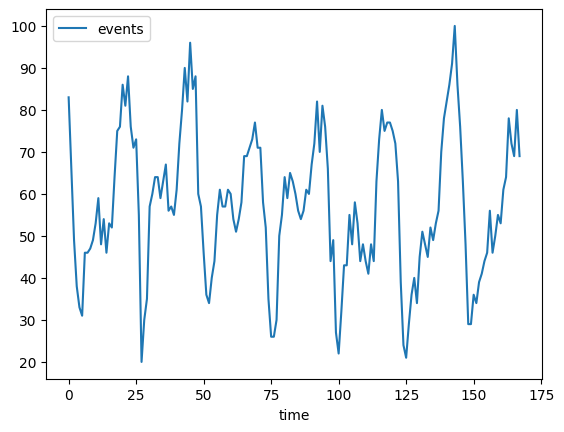

In [54]:
path = "AnneFrank.csv"
AnneFrank = pd.read_csv(path, header=1, names=['time', 'events'])
AnneFrank['date'] = pd.to_datetime(AnneFrank.time)
AnneFrank['time'] = AnneFrank['date'].astype(int) / 3600000000000
AnneFrank['time'] = AnneFrank['time'] - AnneFrank['time'].min()
AnneFrank.plot(x='time', y='events')

In [55]:
AnneFrank

,time,events,date
0,0.0,83,2022-02-14 09:00:00
1,1.0,66,2022-02-14 10:00:00
2,2.0,49,2022-02-14 11:00:00
3,3.0,38,2022-02-14 12:00:00
4,4.0,33,2022-02-14 13:00:00
...,...,...,...
163,163.0,78,2022-02-21 04:00:00
164,164.0,72,2022-02-21 05:00:00
165,165.0,69,2022-02-21 06:00:00
166,166.0,80,2022-02-21 07:00:00


In [56]:
AnneFrank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    168 non-null    float64       
 1   events  168 non-null    int64         
 2   date    168 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 4.1 KB


In this question you will fit a model to the response based on $2p+1$ predictors of the form:
$$
\begin{align}
x_1 = [1,~\ldots~,1]
\end{align}
$$
$$
\begin{align}
x_{2k} & = \sin(2 \pi \cdot k \cdot t / 48) \\
x_{2k+1} & = \cos(2 \pi \cdot k \cdot t / 48), \qquad k=1,\ldots,p
\end{align}
$$
You will then use the selected model to predict the number of events in future times.

1. Write a function ``generate_Z`` that recieves as inputs a vector of time indices (representing hours) ``t`` and ``p``. The function returns the design matrix $Z$ of size $n \times (2p+1)$, where $n$ is the length of ``t``.
2. For each $p=1,\ldots,30$, fit a linear model to ``events`` based on $Z$ you obtain from ``generate_Z`` and evalaute its leave-one-out CV error. Plot the CV error versus $p$.
3. Report on the model with the lowest CV error; plot its response over time along with the original response in the figure above.
4. Using the model you found in 3, predict the number of event at times $t=168.\ldots,190$. Plot your prediction over time in the same figure as above, i.e., interpolate the response curve to future value.
5. For each $t$ in 4, construct a 0.95 prediction interval of your prediction of $y_t$, $t=168,\ldots,190$. Plot the upper and lower limits of this interval over time (these lines define a prediction band). Is this prediction band reliable? what can go wrong?

Hints: (2) In order to evalaute the CV error, you'll need the hat matrix (which you can get directly from Z) and the residuals in the LS fit (which you can get from the ``resid`` property of the fitted model object returned by ``statsmodels.api.OLS.fit``). (4) you can use the function ``predict`` of the fitted model object by passing new predictors that you generate using ``generate_Z``. For (5), $s^2$ is given by the property ``mse_resid`` (or ``ssr`` divided by the number of degrees of freedom). Also note that the number of degrees of freedom is $2p+1$ where $p$ is the number you found in 3.

#### 3.1

In [57]:
def generate_Z(t, p):
    """
    Args:
    ----
    t:   vector of time samples (length n)
    p:   number of frequencies (overal 2p+1 predictors)

    Returns:
    --------
    Z:  design matrix of size (n, 2p+1)
    """

    n = len(t)
    Z = np.ones((n, 2 * p + 1))

    for k in range(1, p + 1):
        Z[:, 2 * k - 1] = np.sin(2 * np.pi * k * t / 48)
        Z[:, 2 * k] = np.cos(2 * np.pi * k * t / 48)

    return Z

#### 3.2

In [58]:
# LOO-CV for p = 1 to 30
loo_cv = []
for p in range(1, 31):
    Z = generate_Z(AnneFrank['time'], p)
    cols = [f'x{i+1}' for i in range(Z.shape[1])]
    Z_df = pd.DataFrame(Z, columns=cols)
    Z_df["events"] = AnneFrank["events"]
    loo_error = leave_one_out_error(Z_df, cols, "events")
    loo_cv.append((p, loo_error))

In [59]:
loo_cv

[(1, 292.9660285810772),
 (2, 155.96935265678127),
 (3, 159.90032579045635),
 (4, 71.66718830901925),
 (5, 73.45639898119764),
 (6, 71.01969361972264),
 (7, 72.10767995756238),
 (8, 68.44304817617788),
 (9, 69.50006641862798),
 (10, 70.3260016249097),
 (11, 72.09907845613043),
 (12, 73.14610959911408),
 (13, 75.06075719804022),
 (14, 76.72865385916239),
 (15, 78.7857313554122),
 (16, 80.84892637828452),
 (17, 83.19106355117302),
 (18, 85.89095223056299),
 (19, 88.43303727033933),
 (20, 91.10592132866618),
 (21, 94.077685027027),
 (22, 96.92809069977935),
 (23, 100.07818763154116),
 (24, 101.53586853266279),
 (25, 101.49329702333576),
 (26, 101.66624934345936),
 (27, 99.77914955165633),
 (28, 95.8010870045167),
 (29, 90.7077031979549),
 (30, 112.18954812338762)]

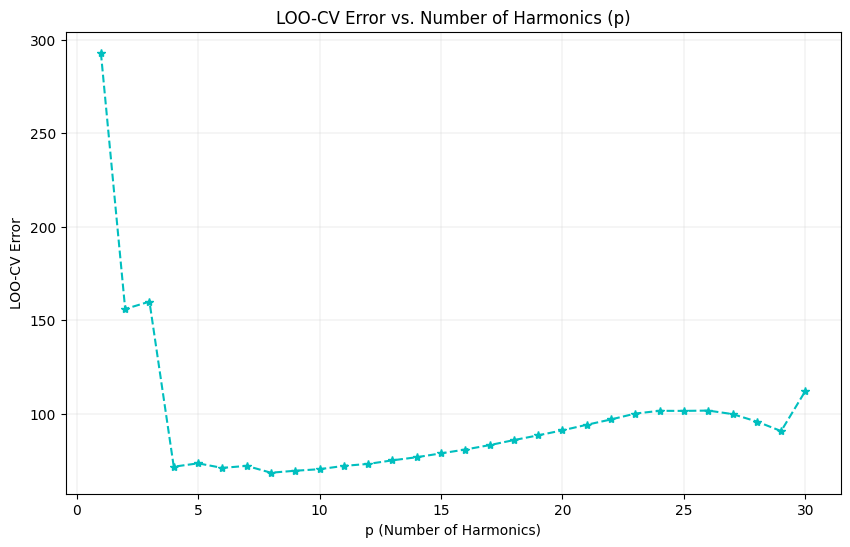

In [60]:
loo_cv_scores_df = pd.DataFrame(loo_cv, columns=['p', 'loo_cv'])
plt.figure(figsize=(10, 6))
plt.plot(loo_cv_scores_df['p'], loo_cv_scores_df['loo_cv'], marker='*', linestyle='--',color='c')
plt.xlabel('p (Number of Harmonics)')
plt.ylabel('LOO-CV Error')
plt.title('LOO-CV Error vs. Number of Harmonics (p)')
plt.grid(color = 'lightgray', linestyle = '-', linewidth = 0.3)
plt.show()

#### 3.3

In [61]:
# find the model with the lowest CV error
loo_cv_scores_df = pd.DataFrame(loo_cv, columns=['p', 'loo_cv'])
loo_cv_scores_df.sort_values(by='loo_cv', ascending=True).head(1)
best_p = loo_cv_scores_df.loc[loo_cv_scores_df['loo_cv'].idxmin(), 'p']

In [62]:
print(f"The model with the lowest CV error has p = {best_p}.")

The model with the lowest CV error has p = 8.


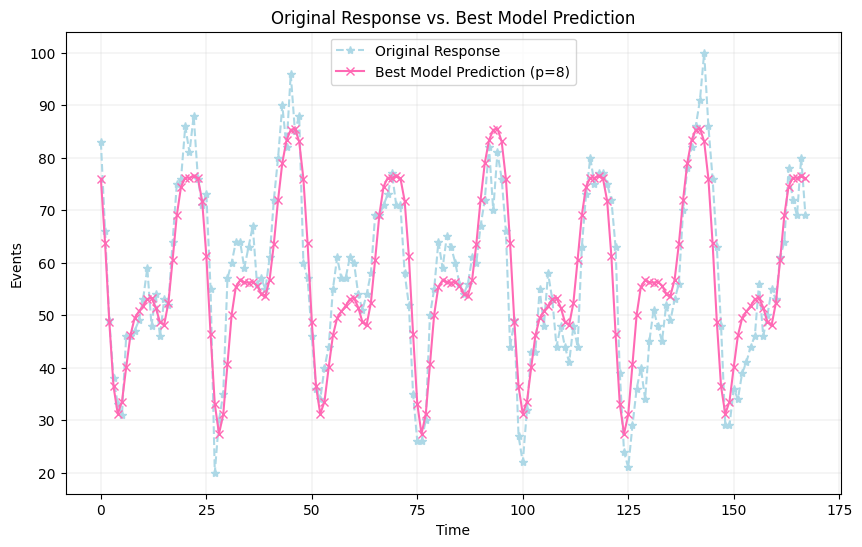

In [63]:
# plot the response for the best model
t = AnneFrank['time']
Z_best = generate_Z(t, int(best_p))
model = sm.OLS(AnneFrank['events'], Z_best).fit()
predicted_events = model.predict(Z_best)
plt.figure(figsize=(10, 6))
plt.plot(t, AnneFrank['events'], label='Original Response', marker='*', linestyle='--', color='lightblue')
plt.plot(t, predicted_events, label=f'Best Model Prediction (p={int(best_p)})', marker='x', color='hotpink')
plt.xlabel('Time')
plt.ylabel('Events')
plt.title('Original Response vs. Best Model Prediction')
plt.legend(loc='best')
plt.grid(color = 'lightgray', linestyle = '-', linewidth = 0.3)
plt.show()

#### 3.4

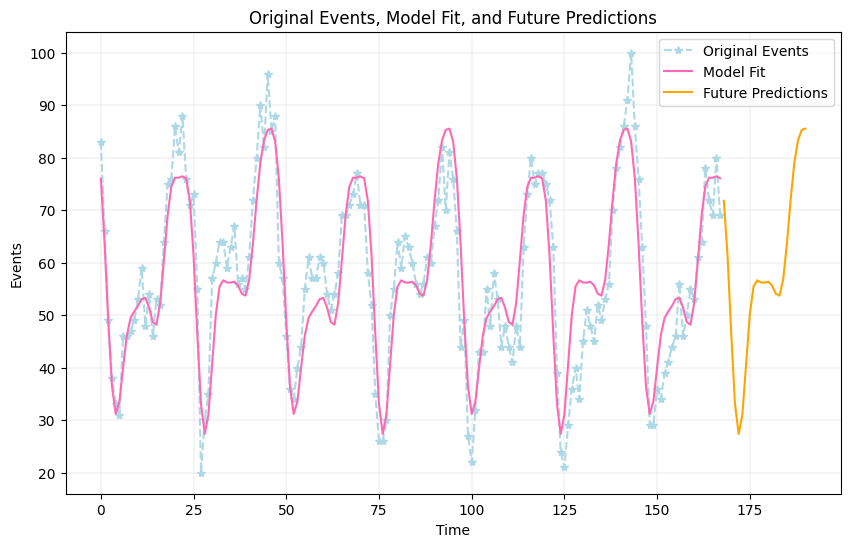

In [64]:
new_time = np.arange(168, 191)
t = AnneFrank['time']
Z_future = generate_Z(new_time, best_p)
y_hat_new = model.predict(Z_future) # pred future events
plt.figure(figsize=(10, 6))
plt.plot(t, AnneFrank['events'], label='Original Events', marker='*', linestyle='--', color='lightblue')
plt.plot(t, predicted_events, label='Model Fit', linestyle='-', color='hotpink')
plt.plot(new_time, y_hat_new, label='Future Predictions', linestyle='-',color='orange')
plt.xlabel('Time')
plt.ylabel('Events')
plt.title('Original Events, Model Fit, and Future Predictions')
plt.legend()
plt.grid(color = 'lightgray', linestyle = '-', linewidth = 0.3)
plt.show()

#### 3.5

In [65]:
# prep for plot
s2 = model.mse_resid
n = len(AnneFrank['time'])
t = scipy.stats.t.ppf(0.975, df=2*best_p+1)
Z = generate_Z(AnneFrank['time'], best_p)
y_hat = model.predict(Z)
y_hat_new = model.predict(generate_Z(new_time, best_p))

upper = y_hat_new + t * np.sqrt(s2 * (1 + 1/n + (new_time - AnneFrank['time'].mean())**2 / ((n-1) * AnneFrank['time'].var())))
lower = y_hat_new - t * np.sqrt(s2 * (1 + 1/n + (new_time - AnneFrank['time'].mean())**2 / ((n-1) * AnneFrank['time'].var())))

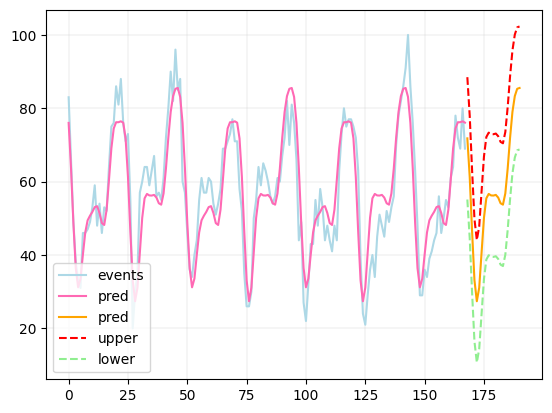

In [66]:
plt.plot(AnneFrank['time'], AnneFrank['events'], label='events', color='lightblue')
plt.plot(AnneFrank['time'], y_hat, label='pred',color='hotpink' )
plt.plot(new_time, y_hat_new, label='pred',color='orange' )
plt.plot(new_time, upper, label='upper', color='r', linestyle='--',)
plt.plot(new_time, lower, label='lower', color = 'lightgreen',linestyle='--',)
plt.grid(color = 'lightgray', linestyle = '-', linewidth = 0.3)
plt.legend(loc=3)

## Problem 4 (Violation of Assumptions)

In this problem you work with the model you fitted in Problem 3 to the data ``AnneFrank``. Make sure you used ``statsmodels`` and printed the model diagnostic information, e.g. using ``model.summary()``
1. What can you say about the assumption that the residuals follow a normal distribution? Which statistic provides relevant information?
2. Plot the model residuals over time. Make a 1-lag residuals plot $\hat{\epsilon}_{i+1}$ vs. $\hat{\epsilon}_{i}$. Do the residual look dependent over time or not? Which statistic provide relevant information?
3. A Fourier analysis reveals that there exist dominant periodic components of time period $20$ hours and $30$ hours in the residuals (you don't have to do the analysis). Argue that this is the case by regressing the residuals over the predictors $x_{1t} = \cos(2\pi t/20)$, $x_{2t} = \sin(2\pi t/20)$, $x_{3t} = \cos(2\pi t/30)$ and $x_{4t} = \sin(2\pi t/30)$, $t=1,\ldots,167$. Indicate how you can deduce that the new model makes sense.
4. What can you say about the 1-lag correlation of the residuals of the new model?


### **Answer Q.4.**

In [67]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 events   R-squared:                       0.808
Model:                            OLS   Adj. R-squared:                  0.788
Method:                 Least Squares   F-statistic:                     39.82
Date:                Mon, 27 Jan 2025   Prob (F-statistic):           6.06e-46
Time:                        11:02:02   Log-Likelihood:                -574.77
No. Observations:                 168   AIC:                             1184.
Df Residuals:                     151   BIC:                             1237.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         57.4733      0.609     94.426      0.000      56.271      58.676
x1            -2.2939      0.861     -2.664      0.009      -3.995      -0.592
x2             2.1491      0.860      2.498      0.014       0.449       3.849
x3           -15.1803      0.861    -17.628      0.000     -16.882     -13.479
x4             6.6888      0.860      7.775      0.000       4.989       8.389
x5            -0.0428      0.861     -0.050      0.960      -1.744       1.659
x6             0.9642      0.860      1.121      0.264      -0.736       2.664
x7           -12.1765      0.861    -14.142      0.000     -13.878     -10.475
x8             4.4746      0.860      5.202      0.000       2.775       6.174
x9            -0.1944      0.861     -0.226      0.822      -1.896       1.507
x10           -0.3186      0.860     -0.370      0.712      -2.018       1.381
x11           -0.1140      0.861     -0.133      0.895      -1.815       1.586
x12            2.8395      0.860      3.302      0.001       1.141       4.538
x13           -0.9084      0.861     -1.056      0.293      -2.609       0.792
x14           -0.6877      0.860     -0.800      0.425      -2.387       1.011
x15            1.7811      0.857      2.078      0.039       0.087       3.475
x16            2.4311      0.856      2.840      0.005       0.740       4.123
==============================================================================
Omnibus:                        2.459   Durbin-Watson:                   0.816
Prob(Omnibus):                  0.293   Jarque-Bera (JB):                2.318
Skew:                          -0.288   Prob(JB):                        0.314
Kurtosis:                       2.978   Cond. No.                         1.54
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### **4.1.**

The Jarque-Bera (JB) statistic in the OLS results serves as an indicator of whether the residuals follow a normal distribution. In this example, the JB value is 2.318, and the test—based on skewness and kurtosis—helps determine if the residuals differ significantly from normal. The associated p-value is 0.314, which exceeds the standard 0.05 threshold, indicating insufficient evidence to reject the null hypothesis of normality. Consequently, the assumption of normally distributed residuals appears reasonable under these findings.

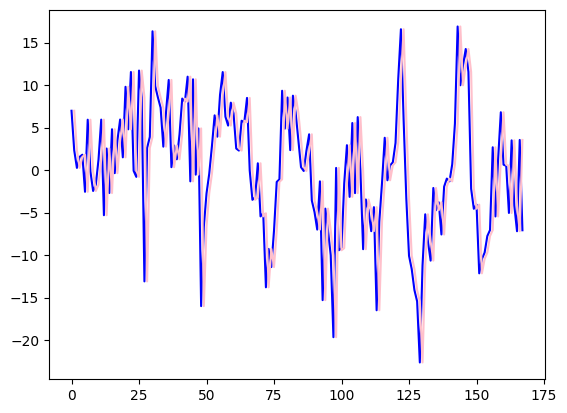

In [68]:
model.resid.plot(color='blue')
model.resid.shift(1).plot(color='pink');

### **4.2.**

The OLS regression results indicate a Durbin-Watson statistic of 0.816. This statistic ranges from 0 to 4, where a value near 2 signals no autocorrelation. Values below 2 point to positive autocorrelation, whereas values above 2 indicate negative autocorrelation. A value of 0.816 suggests the presence of positive autocorrelation.

### **4.3.**

In [69]:
# Extract residuals from the model
residuals = model.resid

# Define the time variable and compute Fourier predictors
time = AnneFrank['time']
x1_t = np.cos(2 * np.pi * time / 20)
x2_t = np.sin(2 * np.pi * time / 20)
x3_t = np.cos(2 * np.pi * time / 30)
x4_t = np.sin(2 * np.pi * time / 30)

# Create a DataFrame containing the Fourier terms and residuals
fourier_data = pd.DataFrame({
    'x1_t': x1_t,
    'x2_t': x2_t,
    'x3_t': x3_t,
    'x4_t': x4_t,
    'residuals': residuals
})

# Fit an OLS regression model to the residuals
fourier_model = sm.OLS(fourier_data['residuals'], fourier_data[['x1_t', 'x2_t', 'x3_t', 'x4_t']]).fit()

# Display the summary of the regression model
print(fourier_model.summary())


                                 OLS Regression Results                                
Dep. Variable:              residuals   R-squared (uncentered):                   0.273
Model:                            OLS   Adj. R-squared (uncentered):              0.255
Method:                 Least Squares   F-statistic:                              15.36
Date:                Mon, 27 Jan 2025   Prob (F-statistic):                    1.09e-10
Time:                        11:02:02   Log-Likelihood:                         -548.04
No. Observations:                 168   AIC:                                      1104.
Df Residuals:                     164   BIC:                                      1117.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

The regression results highlight the significance of the Fourier predictors in accounting for the dominant periodic components in the residuals:

- **Coefficients:** The non-zero coefficients for the Fourier predictors (x1_t, x2_t, x3_t, and x4_t) indicate their influence on the residuals.  
- **P-values:** All p-values are below 0.05, confirming that the coefficients are statistically significant. This demonstrates that the Fourier predictors meaningfully contribute to explaining variations in the residuals.  
- **R-squared:** The R-squared value of 0.273 shows that the model explains approximately 27.3% of the residuals' variance, reflecting an improvement over the initial model. This implies that adding Fourier predictors helps capture some of the key periodic patterns.

In summary, the inclusion of the Fourier predictors (x1_t, x2_t, x3_t, and x4_t) is justified, as they effectively capture periodic components with time periods of 20 and 30 hours in the residuals.

### **4.4.**

To assess the 1-lag correlation of the residuals in the updated model, the Durbin-Watson statistic is examined. The reported value in the regression results is 1.091. This statistic evaluates the degree of first-order serial correlation in the residuals.

For reference, a Durbin-Watson value near 2 indicates minimal autocorrelation, implying that the residuals are largely independent. Values significantly below 2 indicate positive autocorrelation, while values above 2 point to negative autocorrelation.

In this case, the Durbin-Watson value of 1.091 indicates positive autocorrelation, meaning there is noticeable dependence between adjacent residuals at a lag of 1. This level of autocorrelation is more pronounced compared to the model regressed with previous predictors using a 48-hour cycle.

## Problem 5 (A/B Testing)


### 1. What is A/B Testing?

**A/B testing**, also called a **split test** or **controlled experiment**, is a randomized experiment where you compare two (or more) variants of an intervention (e.g., a webpage design, a marketing campaign, or a new drug formulation) to determine which variant performs better according to a pre-defined metric.

1. **Variant A (Control)** – The existing version or baseline.
2. **Variant B (Treatment)** – The new version or proposed change.

The goal is to **measure the causal impact** of switching from A to B on the outcome metric of interest (e.g., conversion rate, average revenue, click-through rate).

<br>

### 2. Why to A/B Test?

A/B tests are a form of **controlled experiment**. By randomly assigning participants (users, subjects) to either variant A or variant B, we aim to **isolate the effect** of the intervention from **confounding factors**. Randomization ensures:

1. **Independence**: Each participant’s assignment to A or B is independent of others.
2. **Balance of Covariates**: On average, both known and unknown confounders (e.g., demographics, user behavior) should be balanced across groups—so the only systematic difference is the intervention itself.

This setting allows us to make **causal inferences** about whether variant B truly improves (or worsens) the key metric compared to A.

<br>

### 3. Setting Up the Experiment

#### 3.1 Defining the Metric

Before launching an A/B test, precisely define the **primary outcome metric** you wish to measure. Common examples:
- **Binary**: Conversion (1 = purchased, 0 = did not purchase).
- **Continuous**: Average time on site, average transaction value, etc.
- **Count**: Number of pages visited, items purchased, etc.

#### 3.2 Random Assignment and Data Collection

- **Randomization**: Each incoming participant is assigned to Group A or Group B with probability 0.5 (or another specified proportion).
- **Sample Size**: Use **power analysis** (or a pre-determined plan) to determine how many participants you need to detect a specified effect size at a chosen significance level $ \alpha $ (often 0.05) with adequate power.
- **Duration**: Continue the experiment until you reach that sample size or a specific time horizon.


<br>

### 4. Statistical Framework

#### 4.1 Formulating the Hypotheses

##### Nominal Response

If we denote $ \mu_A $ as the true mean response for the Control group and $ \mu_B$ for the Treatment group:

- **Null Hypothesis ($ H_0 $)**:
  $ \mu_A = \mu_B $

- **Alternative Hypothesis ($ H_1 $)**
  $ \mu_A \neq \mu_B $
  
##### Binary Response
If we denote $ p_A $ as the true parameter (e.g., conversion rate) for the Control group and $ p_B $ for the Treatment group:

- **Null Hypothesis ($ H_0 $)**:
  $ p_A = p_B $
  (No difference in performance between variants.)

- **Alternative Hypothesis ($ H_1 $)** (Two-sided):
  $ p_A \neq p_B $
  (There is a difference—could be an increase or a decrease.)


<br>

#### 4.2 Test Statistic and Distribution

##### Nominal Response
Use the two-sample $t$-test

##### Binary Response
Use the **two-proportion z-test**:

$ Z = \frac{\hat{p}_A - \hat{p}_B}{\sqrt{\hat{p}(1 - \hat{p})\left(\frac{1}{n_A} + \frac{1}{n_B}\right)}} $

where:
- $ \hat{p}_A $ = observed proportion for Group A (e.g., $ \text{conversions}_A / n_A $)
- $ \hat{p}_B $ = observed proportion for Group B
- $ n_A, n_B $ = number of observations in Groups A and B
- $ \hat{p} $ = "pooled" proportion across both groups (since $ H_0 $ posits $ p_A = p_B $):
  $ \hat{p} = \frac{\#\{\text{conversions in A}\} + \#\{\text{conversions in B}\}}{n_A + n_B} $


You will later prove that under the null hypothesis $p_A=p_B$ and in the large samples sizes limit $n_A \to \infty$ and $n_B\to \infty$, this $ Z $-statistic approximately follows a standard normal ($ N(0, 1) $) distribution.

This leads to the following procedure:

1. **Compute $ Z $**.
2. **Obtain p-value**: Probability of observing a $ Z $-statistic at least as extreme as the observed one, assuming the null hypothesis is true.
3. **Decision**: If $ p\text{-value} < \alpha $, reject $ H_0 $. Otherwise, fail to reject $ H_0 $.

<br>

#### 4.3 Assumptions

1. **Random Assignment**: Observations are randomly allocated to A or B.
2. **Independence**: Observations within and across groups are independent.
3. **Sufficient Sample**: Each group should have at least 5–10 observed successes **and** failures to ensure the normal approximation is valid.
4. **No Major Time Trends**: The underlying conversion probabilities do not drift drastically over the test period.

<br>

### 5. Summary

1. **Concept**: A/B testing is a **randomized controlled experiment** comparing two variants (A=Control, B=Treatment).
2. **Hypothesis**: Typically, $ H_0: p_A = p_B $ vs. $ H_1: p_A \neq p_B $.
3. **Implementation**:
   - Randomly assign users to A or B.
   - Collect data on your primary outcome metric.
   - Use a suitable **statistical test**.
   - Evaluate statistical significance ($ p $-value < $ \alpha $).
4. **Interpretation**:
   - Reject $ H_0 $ if $ p $-value < $ \alpha $ → significant difference in performance.
   - Otherwise, fail to reject $ H_0 $.

By properly designing and analyzing an A/B test, we can **establish a causal link** between design changes (B vs. A) and measured outcomes, which is the cornerstone of **data-driven decision-making** in many industries.


## Assignments:

4.1. Prove that under the null hypothesis $p_A=p_B$ and in the large samples sizes limit $n_A \to \infty$ and $n_B\to \infty$, the $ Z $-statistic presented above converges to a standard normal ($ N(0, 1) $) distribution. Use the following steps:
1. Show that under $H_0$, $\hat{p} \to p_A$ in distribution (Note: this is convergence of a random variable to a constant. Use the law of large numbers)
2. Evaluate the variance of $\hat{p}_A - \hat{p}_B$.
3. Argue that $(\hat{p}_A - \hat{p}_B)/\sqrt{\mathrm{Var}(\hat{p}_A - \hat{p}_B)}$ converges in distribution to a standard normal. Use the central limit theorem.
4. Argue that $Z$ converges to a standard normal distribution. Use the following fact (Slutsky's Theorem): for two sequences of random variables $\{X_n\}$ and $\{Y_n\}$, if $X_n \to X$ in distribution and $Y_n \to c>0$ (a non-zero constant), then $X_n/Y_n \to X/c$ in distribution.

4.2. Practice A/B testing using the dataset 'ab_test_data.csv'. This dataset contains the results of an A/B test where two groups (A and B) were exposed to different versions of a website. The data includes the group assignment, the conversion rate (0/1) and the revenue for each user.
1. Perform an A/B test to compare the conversion rates and average revenue between groups A and B. Explicitly state assumptions, hypotheses, statistical tools you used and conclusions.
2. The CEO would like to know the bottom line: does the new version of the website improve its performance? What would you tell the CEO? (Remember that you conducted multiple tests, so you should support your recommendation with statistical evidence).



### **Answer Q.5.**

### Answer to section 4.1:

1. **Under $H_0$, $\hat{p} \to p_A$ in distribution**

   Under the null hypothesis $$p_A = p_B = p$$

  Then:

   $$\hat{p} = \frac{\text{#\{conversions in A\}} + \text{#\{conversions in B\}}}{n_A + n_B}$$

   is the sample proportion of successes from $(n_A + n_B)$ independent Bernoulli($p$) trials. By the Law of Large Numbers:
   $$
   \hat{p} \xrightarrow{p} p,
   $$
   i.e., $\hat{p}$ converges in probability (hence in distribution) to $p$.

2. **Variance of $\hat{p}_A - \hat{p}_B$**

   Let
   $$\hat{p}_A = \frac{X_A}{n_A} \quad\text{and}\quad \hat{p}_B = \frac{X_B}{n_B},$$
   where
   $$X_A \sim \text{Binomial}(n_A, p) \quad\text{and}\quad X_B \sim \text{Binomial}(n_B, p).$$
   Then:
   $$
   \mathrm{Var}(\hat{p}_A) = \frac{p(1-p)}{n_A},
   \quad
   \mathrm{Var}(\hat{p}_B) = \frac{p(1-p)}{n_B},
   \quad
   \mathrm{Cov}(\hat{p}_A, \hat{p}_B) = 0
   $$
   because the assignments to A and B are independent.
   
   Hence,
   $$
   \mathrm{Var}(\hat{p}_A - \hat{p}_B)
   = \mathrm{Var}(\hat{p}_A) + \mathrm{Var}(\hat{p}_B)
   = p(1-p)\left(\frac{1}{n_A} + \frac{1}{n_B}\right).
   $$

3. **$(\hat{p}_A - \hat{p}_B)/\sqrt{\mathrm{Var}(\hat{p}_A - \hat{p}_B)} \to N(0,1)$ in distribution**

   By the Central Limit Theorem, for large $n_A$ and $n_B$:
   $$
   \hat{p}_A - p \xrightarrow{d} N\Big(0,\ \frac{p(1-p)}{n_A}\Big),
   \quad
   \hat{p}_B - p \xrightarrow{d} N\Big(0,\ \frac{p(1-p)}{n_B}\Big).
   $$
   Since $\hat{p}_A$ and $\hat{p}_B$ are independent, their difference (appropriately scaled) also converges in distribution to a normal with mean 0 and variance
   $p(1-p)\left(\frac{1}{n_A} + \frac{1}{n_B}\right).$
   
   Thus,
   $$
   \frac{\hat{p}_A - \hat{p}_B - (p - p)}{\sqrt{p(1-p)\left(\frac{1}{n_A} + \frac{1}{n_B}\right)}}
   \xrightarrow{d} N(0,1).
   $$

4. **$Z$ converges to $N(0,1)$ (Slutsky’s Theorem)**

   Recall that
   $$
   Z
   = \frac{\hat{p}_A - \hat{p}_B}{\sqrt{\hat{p}(1 - \hat{p})\left(\frac{1}{n_A} + \frac{1}{n_B}\right)}}.
   $$
   Under $H_0$, $\hat{p} \xrightarrow{p} p$. Hence the denominator’s random component $\hat{p}(1-\hat{p})$ converges to $p(1-p)$, a nonzero constant. By Slutsky’s theorem, dividing a sequence of random variables converging in distribution to $N(0,1)$ by another sequence converging in probability to a positive constant preserves the $N(0,1)$ distributional limit. Therefore,
   $$
   Z \xrightarrow{d} N(0,1).
   $$

### Answer to section 4.2:

In [70]:
df = pd.read_csv("./ab_test_data.csv")

df_A = df[df['group'] == 'A']
df_B = df[df['group'] == 'B']

summary_stats = df.groupby('group').agg(
    conversion_rate=('converted', 'mean'),
    average_revenue=('revenue', 'mean'),
    sample_size=('converted', 'count')
)
print("==== SUMMARY STATISTICS ====")
print(summary_stats, "\n")

conversions_A = df_A['converted'].sum()
conversions_B = df_B['converted'].sum()
n_A = len(df_A)
n_B = len(df_B)

count = np.array([conversions_A, conversions_B])
nobs = np.array([n_A, n_B])

z_stat, pval_conversion = proportions_ztest(count, nobs, alternative='two-sided')

print("==== CONVERSION RATE TEST ====")
print(f"Z-statistic = {z_stat:.4f}, p-value = {pval_conversion:.4f}")
if pval_conversion < 0.05:
    print("Conclusion: Reject the null hypothesis. There is a significant difference in conversion rates.")
else:
    print("Conclusion: Fail to reject the null hypothesis. No significant difference in conversion rates.")

revenue_A = df_A['revenue']
revenue_B = df_B['revenue']

t_stat, pval_revenue = ttest_ind(revenue_A, revenue_B, equal_var=False)

print("\n==== REVENUE TEST ====")
print(f"T-statistic = {t_stat:.4f}, p-value = {pval_revenue:.4e} (or {pval_revenue:.4f})")
if pval_revenue < 0.05:
    print("Conclusion: Reject the null hypothesis. There is a significant difference in average revenue.")
else:
    print("Conclusion: Fail to reject the null hypothesis. No significant difference in average revenue.")

# CEO summary
print("\n==== CEO SUMMARY ====")
print(f"Group A (Control) Conversion Rate: {summary_stats.loc['A', 'conversion_rate']:.2%}")
print(f"Group B (New Version) Conversion Rate: {summary_stats.loc['B', 'conversion_rate']:.2%}")
print(f"Group A (Control) Average Revenue: ${summary_stats.loc['A', 'average_revenue']:.2f}")
print(f"Group B (New Version) Average Revenue: ${summary_stats.loc['B', 'average_revenue']:.2f}\n")

if (pval_conversion < 0.05) and (pval_revenue < 0.05):
    print("Both conversion rate and average revenue are significantly higher for the new version. We recommend rolling it out.")
elif (pval_conversion < 0.05) and (pval_revenue >= 0.05):
    print("Conversion rate is significantly higher, but revenue is not significantly different. Likely beneficial to adopt new version.")
elif (pval_conversion >= 0.05) and (pval_revenue < 0.05):
    print("Average revenue is significantly higher, but conversion rate is not significantly different. Consider adopting new version.")
else:
    print("No significant improvements detected in either metric. No strong evidence to switch to the new version.")


==== SUMMARY STATISTICS ====
       conversion_rate  average_revenue  sample_size
group                                               
A                0.153         7.551133         1000
B                0.204        11.278239         1000 

==== CONVERSION RATE TEST ====
Z-statistic = -2.9781, p-value = 0.0029
Conclusion: Reject the null hypothesis. There is a significant difference in conversion rates.

==== REVENUE TEST ====
T-statistic = -3.9980, p-value = 6.6342e-05 (or 0.0001)
Conclusion: Reject the null hypothesis. There is a significant difference in average revenue.

==== CEO SUMMARY ====
Group A (Control) Conversion Rate: 15.30%
Group B (New Version) Conversion Rate: 20.40%
Group A (Control) Average Revenue: $7.55
Group B (New Version) Average Revenue: $11.28

Both conversion rate and average revenue are significantly higher for the new version. We recommend rolling it out.


### **Explanation:**

**4.2.1**

---
1. **A/B Test Comparison for Conversion Rates and Average Revenue**

   **Assumptions:**
   - Random assignment: Each user was randomly assigned to either Group A (control) or Group B (treatment).
   - Independence: User interactions and purchases are independent of each other.
   - Sample sizes: Both groups have enough samples to approximate the normal distribution using the central limit theorem.
   - No time-based or seasonal trends: There are no drastic changes in user behavior during the test period that could bias the results.

   **Hypotheses for Conversion Rate:**
   - Null hypothesis ($H_0$): The conversion rates for Group A ($p_A$) and Group B ($p_B$) are equal.
  $$ H_0: p_A = p_B $$
   - Alternative hypothesis ($H_1$): The conversion rates for Group A and Group B are different.
  $$ H_1: p_A \neq p_B $$

   **Statistical Test for Conversion Rate:**
   - A two-proportion z-test was performed to compare the proportions of conversions between groups.
   - Result: The p-value for the z-test is 0.0029, which is **significantly below** the common significance threshold ($\alpha = 0.05$).
   - Conclusion: Reject the null hypothesis. This suggests that there is a significant difference in conversion rates between the two groups, with Group B (new version) having a higher conversion rate.

   **Hypotheses for Average Revenue:**
   - Null hypothesis ($H_0$): The mean revenue for Group A ($\mu_A$) and Group B ($\mu_B$) are equal.
  $$ H_0: \mu_A = \mu_B $$
   - Alternative hypothesis ($H_1$): The mean revenue for Group A and Group B are different.
  $$ H_1: \mu_A \neq \mu_B $$

   **Statistical Test for Average Revenue:**
   - An independent two-sample t-test (with unequal variances) was performed to compare average revenue.
   - Result: The p-value for the t-test is $6.63 \times 10^{-5}$, which is extremely small and indicates a highly significant difference.
   - Conclusion: Reject the null hypothesis. The new version (Group B) leads to significantly higher average revenue per user compared to the control (Group A).

---

**4.2.2**

2. **Recommendation to the CEO:**
   - Based on the statistical evidence from both tests:
     - The new version of the website (**Group B**) has a **significantly higher conversion rate** (20.4% vs 15.3%).
     - The **average revenue per user** also increased substantially (from approximately 7.55 to 11.28).
   - These improvements are statistically significant, meaning they are unlikely to be due to random chance.
   - **Recommendation**: Roll out the new version (**Group B**) of the website. It is expected to drive better business outcomes by increasing both conversions and revenue.